In [2]:
# 导包
import torch
import os
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import logging
import sys


import matplotlib.pyplot as plt
import logging



from datetime import datetime
import torch.optim as optim

In [2]:
print("当前工作目录:", os.getcwd())

当前工作目录: /tmp/pycharm_project_634/src


In [4]:
log_path = "/data/volume1/wds/log1"

# 移除旧 handler
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# 设置日志系统
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_path, encoding="utf-8", delay=False),
        logging.StreamHandler(sys.stdout)
    ],
    force=True
)

logger = logging.getLogger(__name__)


#强制立即刷新写入文件
for h in logger.handlers:
    if hasattr(h, "flush"):
        h.flush()


input_size = 32
num_classes = 10
num_epochs = 50
batch_size = 64


seed = 42
torch.manual_seed(seed)


mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

In [5]:
# 初始学习率
base_lrs = {
    "SGD": 0.01,
    "Adam": 0.001,
    "RMSprop": 0.001
}


torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


save_dir = "/data/volume1/wds/models" # 模型保存目录
os.makedirs(save_dir, exist_ok=True)

# 日志设置
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_path, mode='a', encoding='utf-8'),
        logging.StreamHandler(sys.stdout)
    ],
    force=True
)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


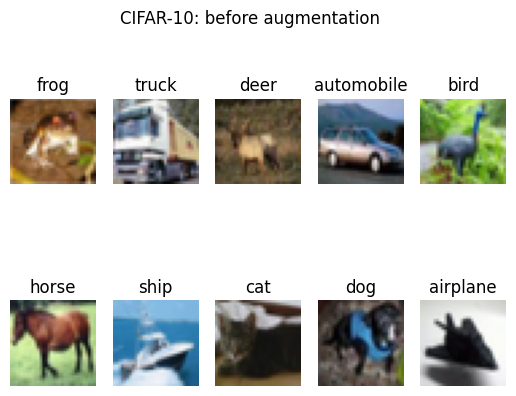

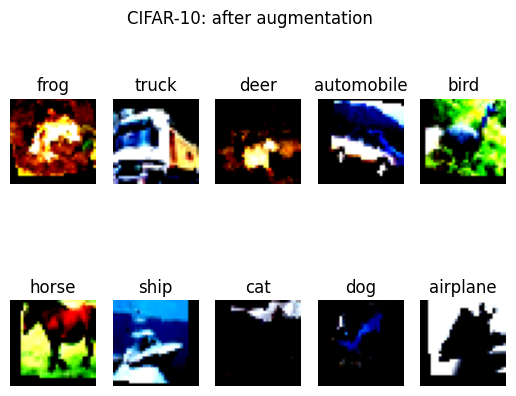

In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # 翻转
    transforms.RandomRotation(15),            # 旋转 ±15 度
    transforms.RandomCrop(32, padding=4),     # 随机裁剪（并填充）
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),    # 颜色抖动
    transforms.RandomGrayscale(p=0.05),       # 随机灰度


    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


test_transform = transforms.Compose([   # 测试不用数据增强，只需要转化为张良
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])



train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)  # 训练集
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)  # 测试集


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = train_dataset.classes
print(classes)



def imshow_tensor(img_tensor):# 展示张量
    img = img_tensor.clone().cpu()   # 需要放在cpu上
    for t, m, s in zip(img, mean, std):
        npimg = img.numpy().transpose((1,2,0)) # 把(C,H,W)调整为(H,W,C)
        npimg = np.clip(npimg, 0, 1)  # 将像素值限制在[0,1]范围内
        plt.imshow(npimg)
        plt.axis('off')
train_dataset_1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms.ToTensor())  # 只是加载了数据集，并没有做数据增强
examples_per_class_1 = {}
examples_per_class = {}
for img, label in train_dataset_1:
    if label not in examples_per_class_1:
        examples_per_class_1[label] = img
    if len(examples_per_class_1) == len(classes):
        break

for idx, (label, img) in enumerate(examples_per_class_1.items()):
    plt.subplot(2,5,idx+1)
    imshow_tensor(img)
    plt.title(classes[label])
plt.suptitle("CIFAR-10: before augmentation")
plt.show()

for img, label in train_dataset:
    if label not in examples_per_class:
        examples_per_class[label] = img
    if len(examples_per_class) == len(classes):
        break
for idx, (label, img) in enumerate(examples_per_class.items()):
    plt.subplot(2,5,idx+1)
    imshow_tensor(img)
    plt.title(classes[label])
plt.suptitle("CIFAR-10: after augmentation")
plt.show()


class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # 32*32 -> 16*16
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # block5
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) # 16*16 -> 8*8
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*1*1, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avgpool(x)
        x = self.fc(x)
        return x



def accuracy(output, target):  # output:[batch_size, num_classes]
    pred = torch.argmax(output, dim=1)  # 沿着第1个维度（类别维度）取最大值索引
    correct = pred.eq(target).sum().item()
    total = target.size(0)
    return correct, total





def train_1_epoch(model,loader,criterion,optimizer,device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)  # 因为nn.CrossEntropyLoss()默认返回的loss是batch中的所有样本平均值
        c, t = accuracy(output, target)
        running_correct += c
        running_total += t
    epoch_loss = running_loss / running_total
    epoch_acc = 100.0 * running_correct / running_total
    return epoch_loss, epoch_acc



def evaluate(model, loader, criterion, device):
    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            eval_loss += loss.item() * data.size(0)
            c, t = accuracy(output, target)
            eval_correct += c
            eval_total += t
    eval_loss = eval_loss / eval_total
    eval_acc = 100.0 * eval_correct / eval_total
    return eval_loss, eval_acc



2025-10-27 11:17:36,546 - INFO - 开始训练 -> 优化器: RMSprop
2025-10-27 11:17:57,498 - INFO - Epoch [1/50]  损失: 1.9205  训练准确率: 26.93%  测试准确率: 42.15%  lr: 0.000999
2025-10-27 11:18:18,370 - INFO - Epoch [2/50]  损失: 1.4916  训练准确率: 45.37%  测试准确率: 46.85%  lr: 0.000996
2025-10-27 11:18:39,166 - INFO - Epoch [3/50]  损失: 1.2933  训练准确率: 53.94%  测试准确率: 55.92%  lr: 0.000991
2025-10-27 11:18:59,950 - INFO - Epoch [4/50]  损失: 1.1833  训练准确率: 58.21%  测试准确率: 56.77%  lr: 0.000984
2025-10-27 11:19:20,777 - INFO - Epoch [5/50]  损失: 1.0959  训练准确率: 61.66%  测试准确率: 59.61%  lr: 0.000976
2025-10-27 11:19:41,585 - INFO - Epoch [6/50]  损失: 1.0464  训练准确率: 63.62%  测试准确率: 67.42%  lr: 0.000965
2025-10-27 11:20:02,424 - INFO - Epoch [7/50]  损失: 0.9973  训练准确率: 65.76%  测试准确率: 59.41%  lr: 0.000952
2025-10-27 11:20:23,403 - INFO - Epoch [8/50]  损失: 0.9600  训练准确率: 67.09%  测试准确率: 69.45%  lr: 0.000938
2025-10-27 11:20:44,245 - INFO - Epoch [9/50]  损失: 0.9488  训练准确率: 67.52%  测试准确率: 69.25%  lr: 0.000922
2025-10-27 11:21:05,030 - I

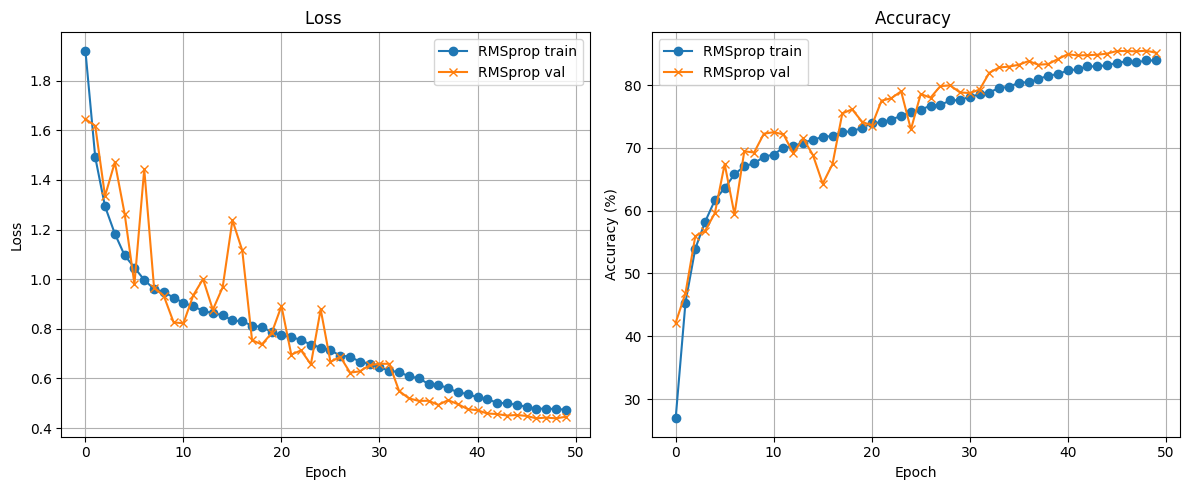

2025-10-27 11:34:59,390 - INFO - 
最终测试准确率汇总：
2025-10-27 11:34:59,391 - INFO - RMSprop: 最后一个 epoch 测试集准确率 = 85.14%


In [9]:
criterion = nn.CrossEntropyLoss()
optimizers = {"RMSprop": lambda params, lr: optim.RMSprop(params, lr=lr, alpha=0.9,momentum=0.9, weight_decay=1e-4)}
# 记录每个优化器的历史（loss/acc）
history = {}
for opt_name, opt_fn in optimizers.items():
    print("\n" + "="*60)
    logging.info(f"开始训练 -> 优化器: {opt_name}")
    model = ConvNet(num_classes=num_classes).to(device)
    lr = base_lrs.get(opt_name, 0.001) # 0.001默认值，如果opt_name不存在就自动训练0.001
    optimizer = opt_fn(model.parameters(), lr=lr)

    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # 学习率调度
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs) # 余弦退火

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    start_time = datetime.now()
    for epoch in range(num_epochs):
        t_loss, t_acc = train_1_epoch(model, train_loader, criterion, optimizer, device) # 训练
        v_loss, v_acc = evaluate(model, test_loader, criterion, device) # 评估
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc)
        val_losses.append(v_loss)
        val_accs.append(v_acc)
        logging.info('Epoch [{}/{}]  损失: {:.4f}  训练准确率: {:.2f}%  测试准确率: {:.2f}%  lr: {:.6f}'.format(
            epoch+1, num_epochs, t_loss, t_acc, v_acc, optimizer.param_groups[0]['lr']
        ))
    elapsed = datetime.now() - start_time
    logging.info(f"{opt_name} 训练完成，耗时: {elapsed}")
    # 保存模型权重
    model_path = os.path.join(save_dir, f"convnet_{opt_name}_1.pth")
    torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': {
        'train_losses': train_losses, 'train_accs': train_accs,
        'val_losses': val_losses, 'val_accs': val_accs
        },
        'epoch': num_epochs,
        'timestamp': datetime.now().isoformat()
    }, model_path)


    # 存入 history 便于后续绘图比较
    history[opt_name] = {
        'train_losses': train_losses, 'train_accs': train_accs,
        'val_losses': val_losses, 'val_accs': val_accs,
        'model_path': model_path
    }

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for opt_name, h in history.items():
        plt.plot(h['train_losses'], marker='o', label=f'{opt_name} train')
        plt.plot(h['val_losses'], marker='x', label=f'{opt_name} val')

    plt.title('Loss ')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    for opt_name, h in history.items():
        plt.plot(h['train_accs'], marker='o', label=f'{opt_name} train')
        plt.plot(h['val_accs'], marker='x', label=f'{opt_name} val')
    plt.title('Accuracy ')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
logging.info("\n最终测试准确率汇总：")
for opt_name, h in history.items():
    final_val_acc = h['val_accs'][-1]
    logging.info(f"{opt_name}: 最后一个 epoch 测试集准确率 = {final_val_acc:.2f}%")